# NMF analysis on calcium movies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
import os

from patchnmf.analyse.nmf import cv_nmf
from patchnmf.analyse.compute import downsample_tiff_avg, compute_nmfpx_blur_thr, get_loading_times
from patchnmf.simulate import poiss_train, make_sim_path, run_simulation, reshape_list_im_to_mat, plot_covmat, covariance_sort 
from patchnmf.plot import plot_nmfpx_blur_thr, plot_roi_loading_time, plot_roi_loading_time, plot_compare_px_truth_nmf, plot_cv_opt, plot_compare_t_truth_nmf, animate_movie

# reload code if library changes
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Setting parameters

In [2]:
# setting simulation params
class SimParams:
    def __init__(self):
        
        self.sim_id = 'sim01'
        
        self.xy_px = 64 
        self.t_max = 2056
        self.patch_size_max = 10
        self.patch_size_min = 5
        self.poiss_tau = 300
        self.act_tau = 32
        self.kernel_range = 256
        self.im_noise = 1.5
        self.smoothing_sigma = 2
        self.n_patches = 7
        self.act_scaling = 3

params = SimParams()

In [3]:
# setting analysis/NMF params
# setting nmf params
n_components = params.n_patches + 5 # plot 5 additional components
blur_std = 1 # blur to get pxNMF smoothed/binary masks (like in real data)

In [4]:
# setting cv nmf params
replicates = 1 # can be run multiple times for robustness
r_max = n_components
step = 1 # increase step for long simulations

## Start of script

In [5]:
# this will be where all the simulation data and outputs are stored under the 'data' folder
sim_path = make_sim_path(params.sim_id)

In [6]:
# this simulates the movie and gives the true patches and how they are activated over time. It also gives a movie by adding all of these and some noise
truth_pxs, truth_ts, movie = run_simulation(params)

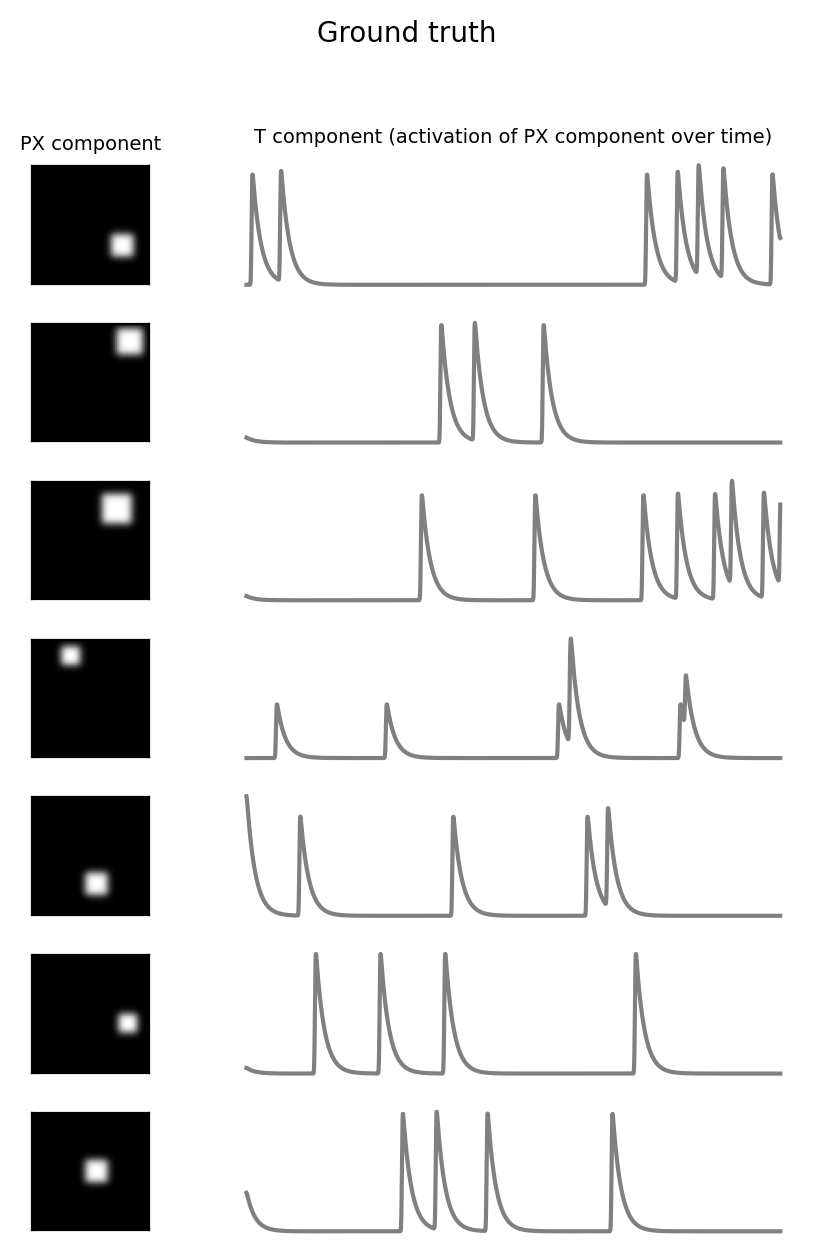

In [7]:
# plot of how true patches get activated over time
plot_roi_loading_time(truth_pxs, truth_ts, title='Ground truth')

MovieWriter ffmpeg unavailable; using Pillow instead.


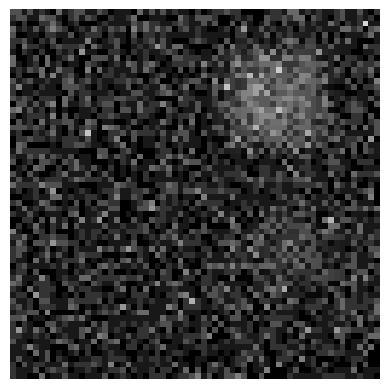

In [8]:
# gif of the 'movie'
animate_movie(movie, sim_path)

# Running NMF on simulations (this is the same as is done on tiffs of data - see comments in that notebook)

In [9]:
movie_flat = np.reshape(movie, (movie.shape[0] , movie.shape[1]*movie.shape[2]))
print(f'Shape of video as a matrix (input to NMF): {movie_flat.shape}') 

Shape of video as a matrix (input to NMF): (2056, 4096)


In [10]:
# run nmf on pixels
nmf_px = NMF(n_components=n_components)
nmf_px.fit(movie_flat);

In [11]:
loading_imgs, loading_imgs_filt, rois_auto = compute_nmfpx_blur_thr(nmf_px, movie.shape, blur_std=blur_std)

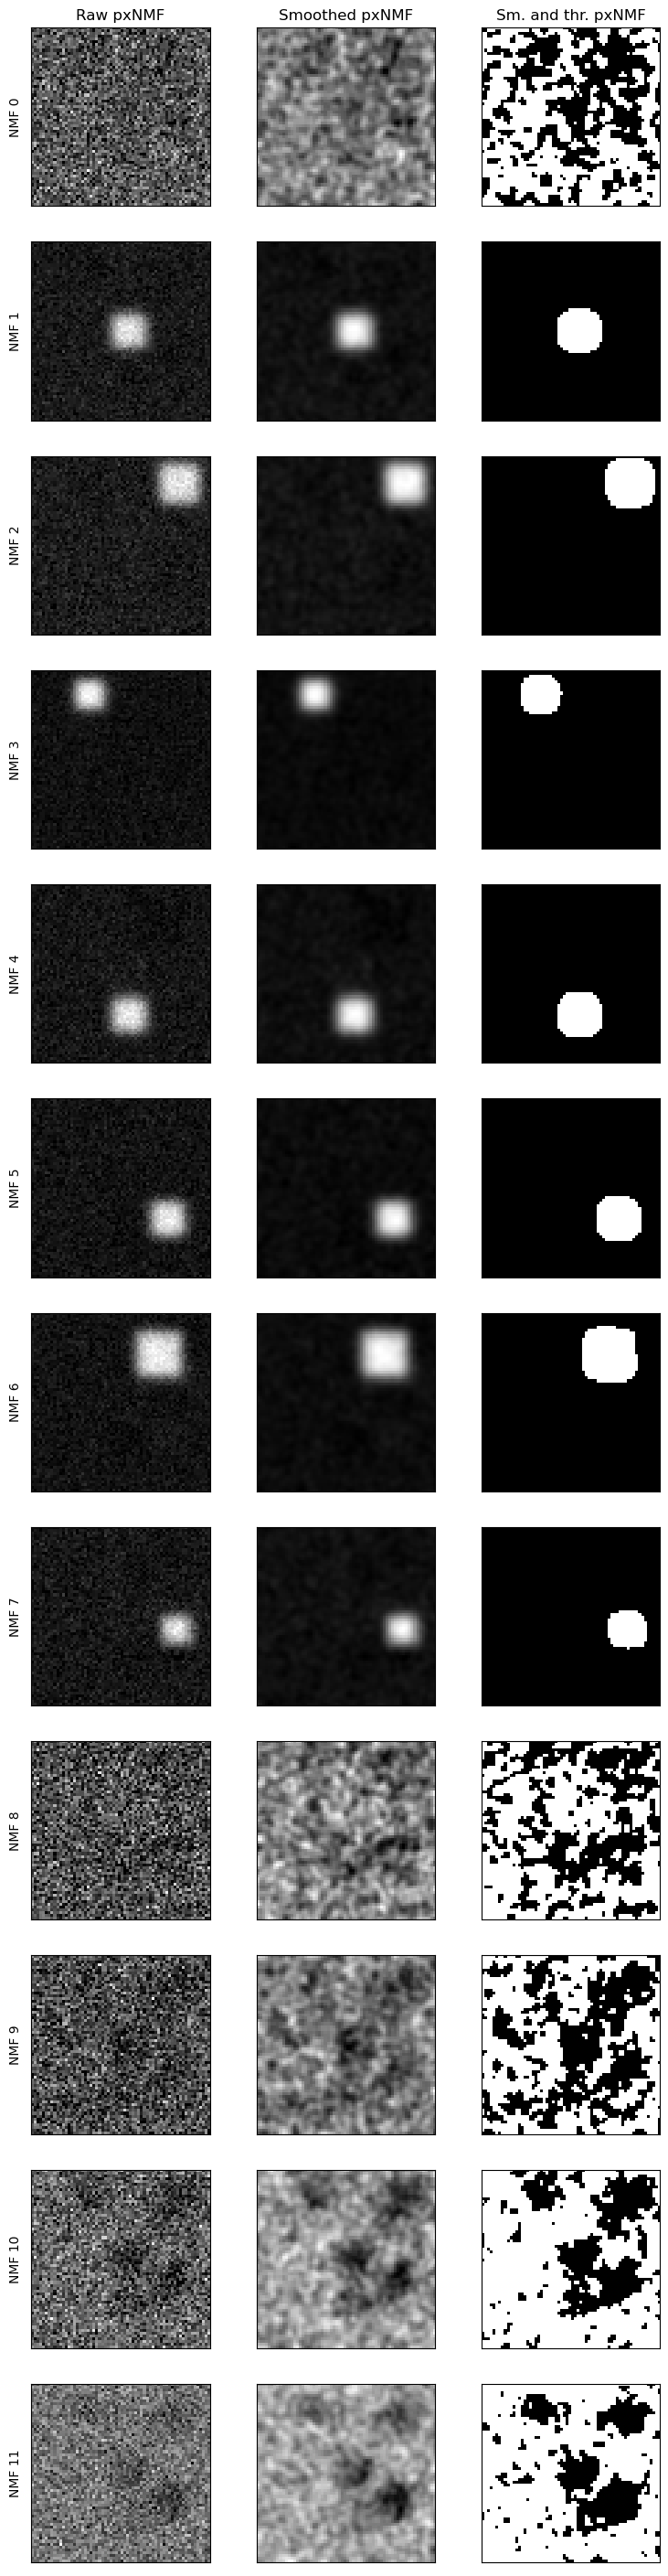

In [12]:
plot_nmfpx_blur_thr(loading_imgs, loading_imgs_filt, rois_auto)

In [13]:
# run nmf on time
nmf_t = NMF(n_components=n_components)
nmf_t.fit(movie_flat.T);

In [14]:
loading_times = get_loading_times(nmf_t)

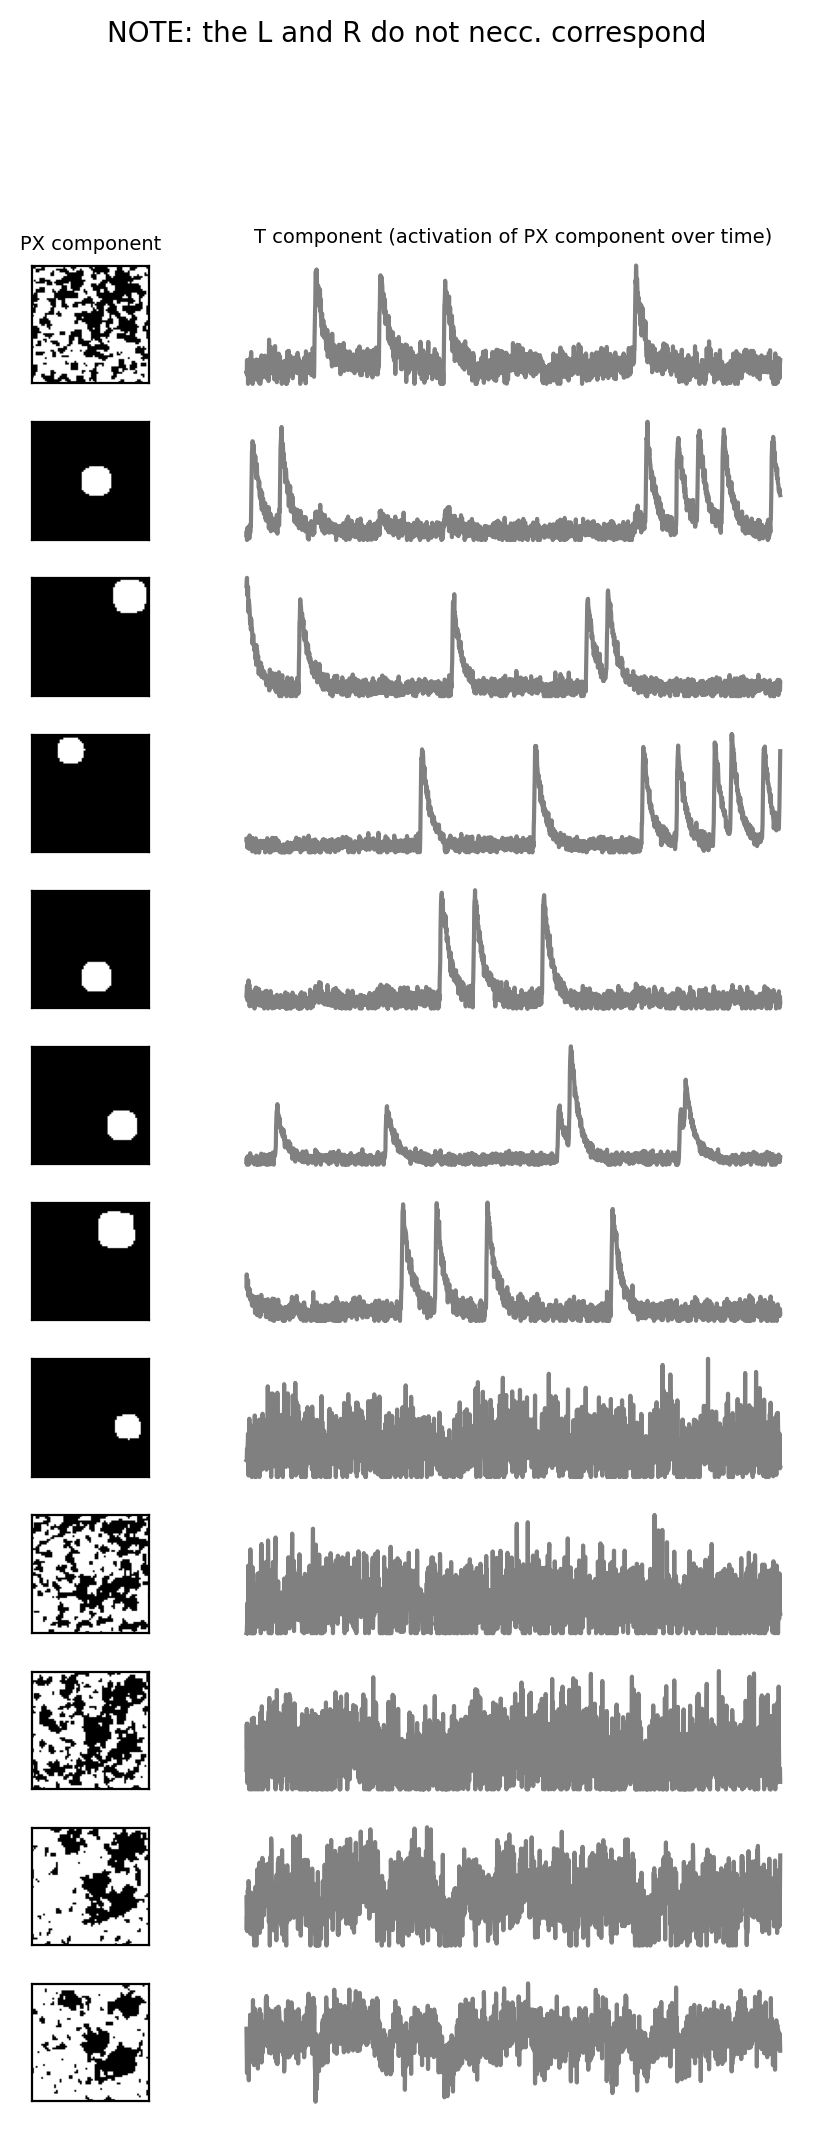

In [15]:
plot_roi_loading_time(rois_auto, loading_times)

## Comparing NMF and ground truth
This is an extra step we can do here that we couldn't when doing NMF on real movies. Because we have the ground truth data we can check which ground truth an NMF component is most similar to. We can then take this component and compare it to the real patches both in pixels and in time.

Sorting by indices (maxima along columns): [0 6 1 3 4 0 2 5 6 3 4 4]



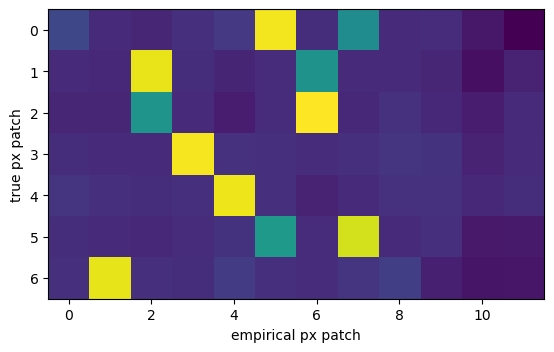

In [16]:
# visualising the method to check which true patch is the most similar to NMF, the most yellow entry in the column is chosen (highest correlation)
sort_ind_px = covariance_sort(truth_pxs, loading_imgs)

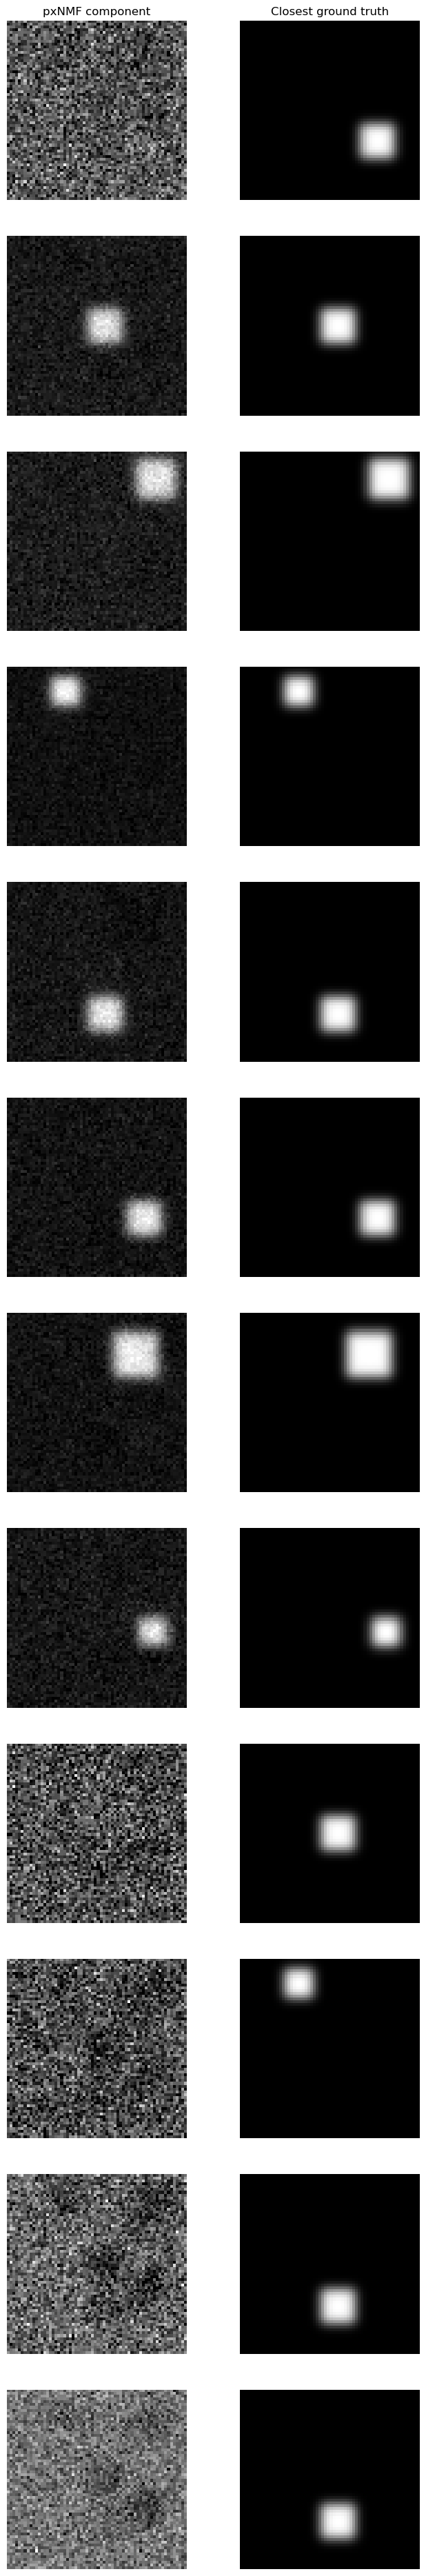

In [17]:
# plotting the pxNMF with the most similar real patch side by side shows NMF did an ok job
plot_compare_px_truth_nmf(sort_ind_px, truth_pxs, loading_imgs)

Sorting by indices (maxima along columns): [5 0 4 2 1 3 6 1 1 1 4 0]



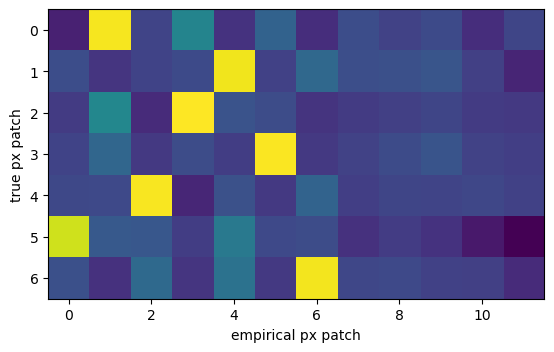

In [18]:
# visualising the method to check which true patch is the most similar to NMF, the most yellow entry in the column is chosen (highest correlation)
sort_ind_t = covariance_sort(truth_ts, loading_times)

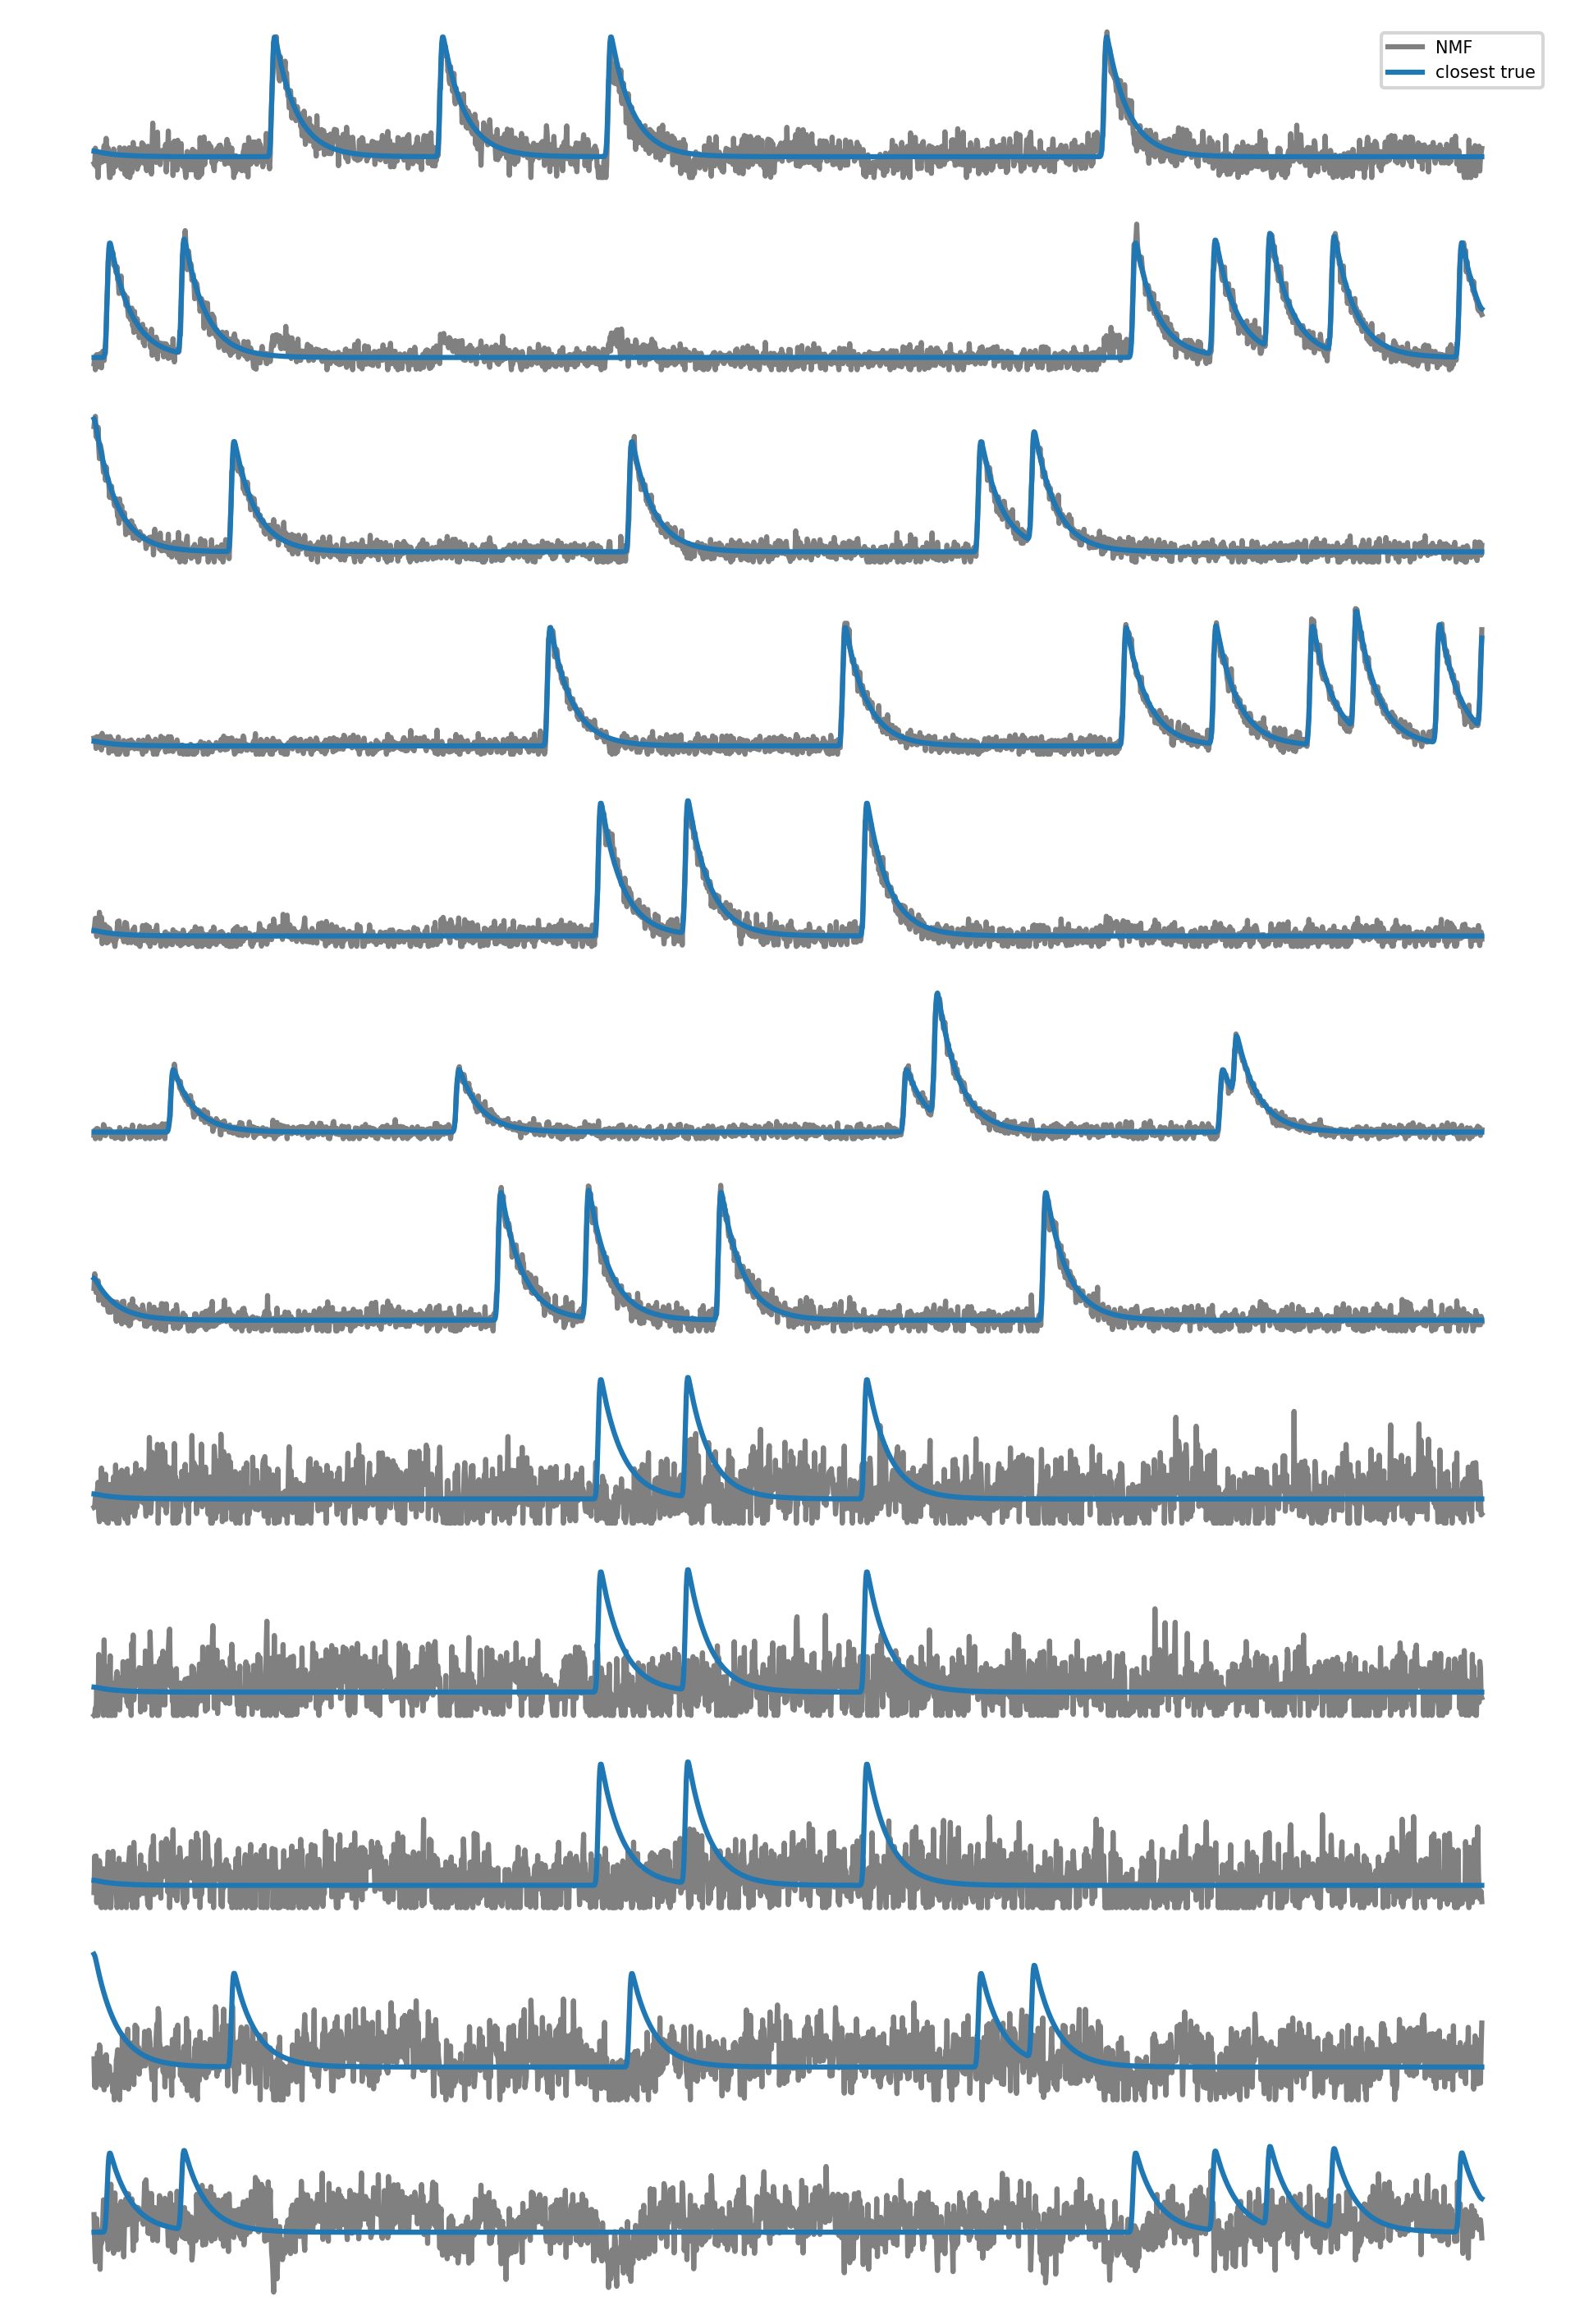

In [19]:
# plotting the tNMF with the most similar real patch activation overlaid shows NMF did an ok job
plot_compare_t_truth_nmf(sort_ind_t, truth_ts, loading_times)

# Cross-validation

For more information see for example:  

- http://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/  
- https://www.cell.com/neuron/fulltext/S0896-6273(22)00588-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0896627322005888%3Fshowall%3Dtrue  
- https://www.cell.com/current-biology/fulltext/S0960-9822(20)30638-2?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0960982220306382%3Fshowall%3Dtrue

In [20]:
# This is a loop to determine optimal number of NMF components from data
train_err, test_err = cv_nmf(movie_flat, r_max, step, replicates)

finished running for rank: 0 out of 12 (step = 1)
finished running for rank: 1 out of 12 (step = 1)
finished running for rank: 2 out of 12 (step = 1)
finished running for rank: 3 out of 12 (step = 1)
finished running for rank: 4 out of 12 (step = 1)
finished running for rank: 5 out of 12 (step = 1)
finished running for rank: 6 out of 12 (step = 1)
finished running for rank: 7 out of 12 (step = 1)
finished running for rank: 8 out of 12 (step = 1)
finished running for rank: 9 out of 12 (step = 1)
finished running for rank: 10 out of 12 (step = 1)
finished running for rank: 11 out of 12 (step = 1)


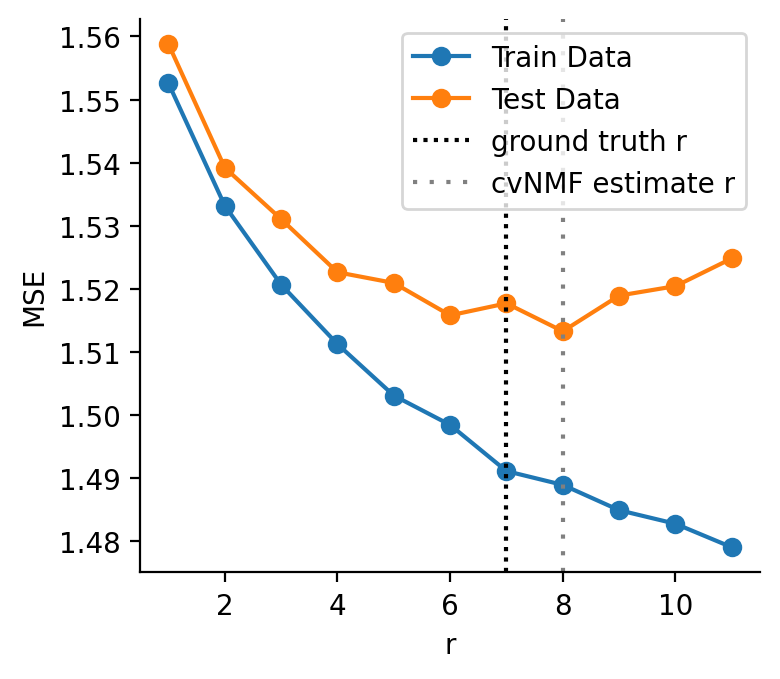

In [21]:
# Visualising the train and test errors + the real number of components and the identified optimum
plot_cv_opt(params, train_err, test_err)